In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

%load_ext autoreload
%autoreload

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm

In [3]:
from utils import datasets, tscp, metrics, mmd

from utils.ensembles import EnsembleCPDModel #, MMDEnsembleCPDModel
from utils.visualize import visualize_predictions

import yaml

from torch.utils.data import DataLoader

# Synthetic sequences of scores

## Normal

In [4]:
def generate_synthetic_normal_cp(
    cp_loc = 32,
    sigma = 0.01, 
    seq_len = 64,
    cp_delta = 0,
):
    if cp_delta > 0:
        cp_loc = torch.randint(cp_loc - cp_delta, cp_loc + cp_delta, size=[1]).item()
    
    start_len = cp_loc
    end_len = seq_len - cp_loc

    seq_start  = torch.normal(torch.zeros(start_len), sigma * torch.ones(start_len))
    seq_finish = torch.normal(torch.ones(end_len), sigma * torch.ones(end_len))

    means_seq = torch.hstack((seq_start, seq_finish))
        
    labels = torch.hstack((torch.zeros(start_len), torch.ones(end_len)))
    
    return means_seq, labels

def generate_synthetic_normal(
    sigma = 0.01, 
    seq_len = 64,
):  
    means_seq = torch.normal(torch.zeros(seq_len), global_sigma * torch.ones(seq_len))
    labels = torch.zeros(seq_len)

    return means_seq, labels

## Beta

In [7]:
from torch.distributions.beta import Beta

In [8]:
def beta_moments(alpha, beta):
    exp = alpha / (alpha + beta)
    var = alpha * beta / (alpha + beta) ** 2 / (alpha + beta + 1)
    return exp, var

In [9]:
beta_moments(1, 10), beta_moments(10, 1)

((0.09090909090909091, 0.006887052341597796),
 (0.9090909090909091, 0.006887052341597796))

In [10]:
def generate_synthetic_beta_cp(
    cp_loc = 32,
    conc_norm = (1, 10), 
    conc_abnorm = (10, 1),
    seq_len = 64,
    cp_delta = 0
):
    if cp_delta > 0:
        cp_loc = torch.randint(cp_loc - cp_delta, cp_loc + cp_delta, size=[1]).item()
    
    start_len = cp_loc
    end_len = seq_len - cp_loc

    seq_start  = Beta(*conc_norm  ).sample([start_len])
    seq_finish = Beta(*conc_abnorm).sample([end_len])

    means_seq = torch.hstack((seq_start, seq_finish))
        
    labels = torch.hstack((torch.zeros(start_len), torch.ones([end_len])))
    
    return means_seq, labels

def generate_synthetic_beta(
    conc_norm = (1, 10), 
    seq_len = 64,
):  
    means_seq = Beta(*conc_norm).sample([seq_len])
    labels = torch.zeros(seq_len)

    return means_seq, labels

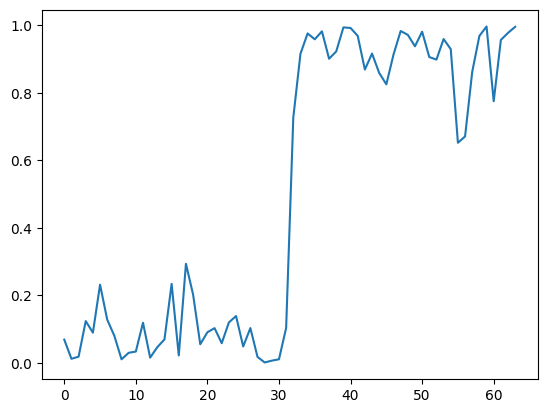

In [11]:
preds_beta, _ = generate_synthetic_beta_cp(
    cp_loc=32,
    conc_norm=(1, 10), 
    conc_abnorm=(10, 1),
    seq_len=64,
    cp_delta=0
)
plt.plot(preds_beta)
plt.show()

# Experiments: Normal

## Fixed sigma, different wnd_size

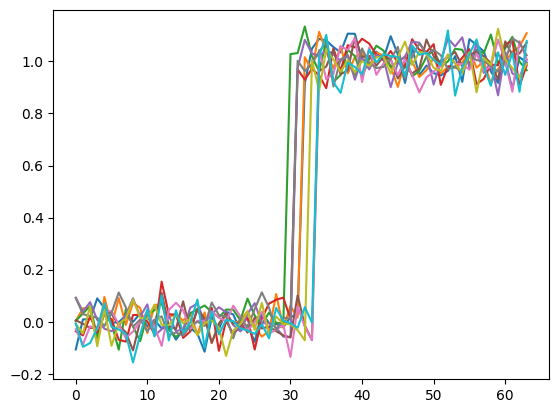

In [12]:
NUM_MODELS = 10
CP_LOC = 32
SIGMA = 0.05 
SEQ_LEN = 64
CP_DELTA = 3

fake_ensemble_preds = torch.stack(
    [
        generate_synthetic_normal_cp(
            cp_loc=CP_LOC, sigma=SIGMA, seq_len=SEQ_LEN, cp_delta=CP_DELTA
        )[0] for _ in range(NUM_MODELS)
    ]
).unsqueeze(1)

plt.plot(fake_ensemble_preds[:, 0, :].T) # fake batch of size 1
plt.show()

In [13]:
fake_ensemble_preds.shape # should be (n_models, batch_size, seq_len)


torch.Size([10, 1, 64])

### Fixed-kernel MMD from Kaggle

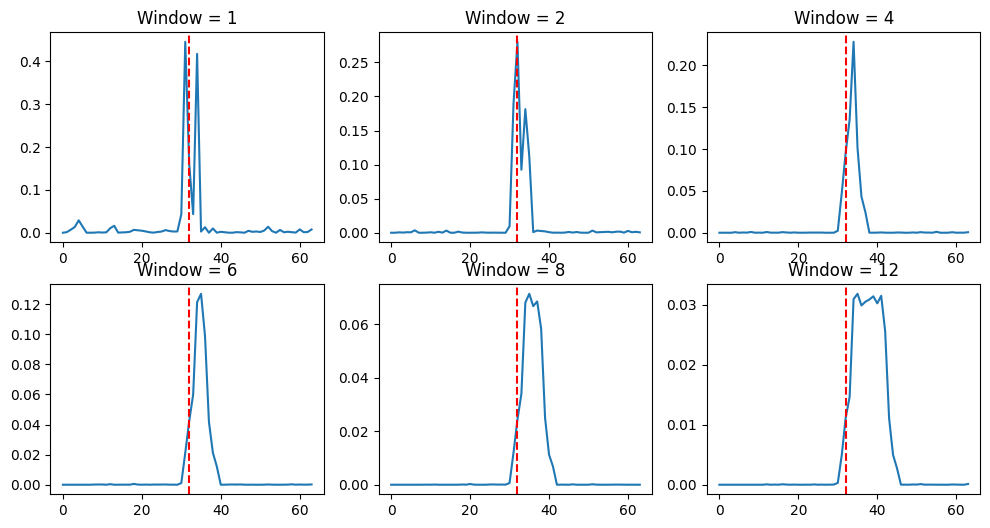

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6)) # (n_rows, n_cols)

for i, wnd_size in enumerate([1, 2, 4, 6, 8, 12]):
    mmd_scores = mmd.sliding_window_mmd_batch(
        fake_ensemble_preds, wnd_size, kernel="rbf", bandwidth_range=[0.2500, 0.5000, 1.0000, 2.0000, 4.0000]
    )[0] # fake batch of size 1
    axs[i // 3, i % 3].plot(mmd_scores, label="Sliding window MMD scores")
    axs[i // 3, i % 3].axvline(32, linestyle="--", c="red", label="True CP loc")
    axs[i // 3, i % 3].set_title(f"Window = {wnd_size}")

In [15]:
%timeit mmd_scores = mmd.sliding_window_mmd_batch(fake_ensemble_preds, window_size=5, kernel="rbf")[0] # fake batch of size 1

27.6 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
mmd_scores.shape

torch.Size([64])

### MMD scores from klcpd module

In [16]:
from utils import klcpd

def sliding_window_mmd_batch_klcpd(
    ensemble_preds, window_size, med_sqdist: float = 1., step: int = 1
) -> torch.Tensor:
    _, batch_size, seq_len = ensemble_preds.shape
    
    sigma_var = torch.FloatTensor(klcpd.median_heuristic(med_sqdist, beta=0.5))

    time_range = torch.arange(seq_len)
    start_pos = time_range[0 : seq_len - window_size + 1 : step]
    idxs_list = [time_range[s : s + window_size] for s in start_pos]

    # first window_size elements are zeros
    mmd_scores_batch = torch.zeros((batch_size, seq_len))

    for i, (history_idx, future_idx) in enumerate(zip(idxs_list[:-1], idxs_list[1:])):
        X = ensemble_preds[:, :, history_idx].transpose(0, 1).reshape(batch_size, -1, 1) # (batch_size, window_size*n_models, 1)
        Y = ensemble_preds[:, :, future_idx].transpose(0, 1).reshape(batch_size, -1, 1)
        
        #mmd_batch = mmd.MMD_batch(X, Y, kernel="rbf")
        mmd_batch_klcpd = klcpd.batch_mmd2_loss(X, Y, sigma_var=sigma_var)
        
        #print("mmd_batch:", mmd_batch.shape)
        #print("mmd_batch_klcpd:", mmd_batch_klcpd.shape)

        mmd_scores_batch[:, window_size + i] = mmd_batch_klcpd

    return mmd_scores_batch

In [20]:
a = torch.randn(32, 20, 5)
b = torch.randn(32, 20, 5)

sigma_list = klcpd.median_heuristic(med_sqdist=1., beta=0.5)
sigma_var = torch.FloatTensor(sigma_list)
sigma_var

tensor([0.2500, 0.5000, 1.0000, 2.0000, 4.0000])

In [21]:
%timeit klcpd.batch_mmd2_loss(a, b, sigma_var=sigma_var)

40.9 ms ± 772 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit mmd.MMD_batch(a, b, kernel="rbf", bandwidth_range=[0.2500, 0.5000, 1.0000, 2.0000, 4.0000])

943 µs ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [18]:
%timeit mmd_scores = sliding_window_mmd_batch_klcpd(fake_ensemble_preds, window_size=5)[0] # fake batch of size 1

89.9 ms ± 3.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


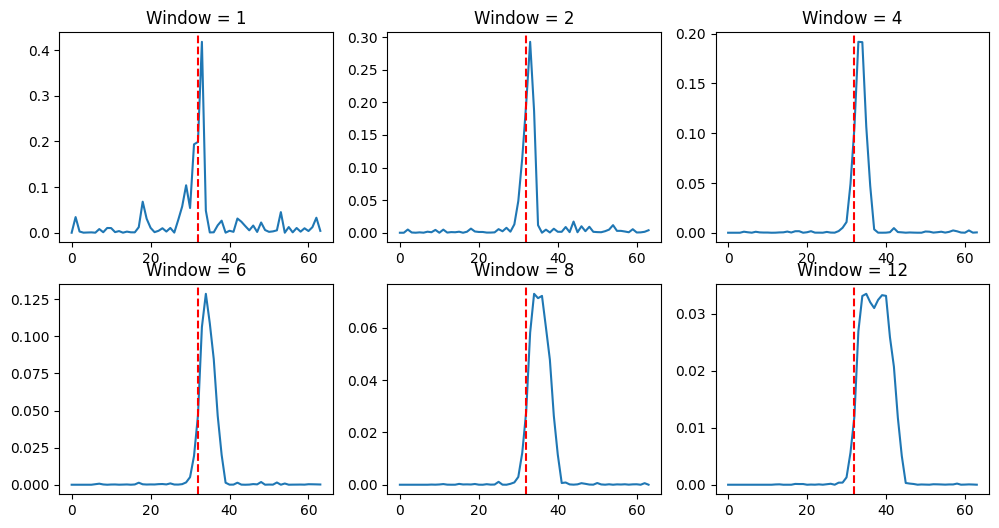

In [58]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6)) # (n_rows, n_cols)

for i, wnd_size in enumerate([1, 2, 4, 6, 8, 12]):
    mmd_scores = sliding_window_mmd_batch_klcpd(fake_ensemble_preds, window_size=wnd_size, med_sqdist=1.)[0] # fake batch of size 1
    axs[i // 3, i % 3].plot(mmd_scores, label="Sliding window MMD scores")
    axs[i // 3, i % 3].axvline(32, linestyle="--", c="red", label="True CP loc")
    axs[i // 3, i % 3].set_title(f"Window = {wnd_size}")

### Different variances

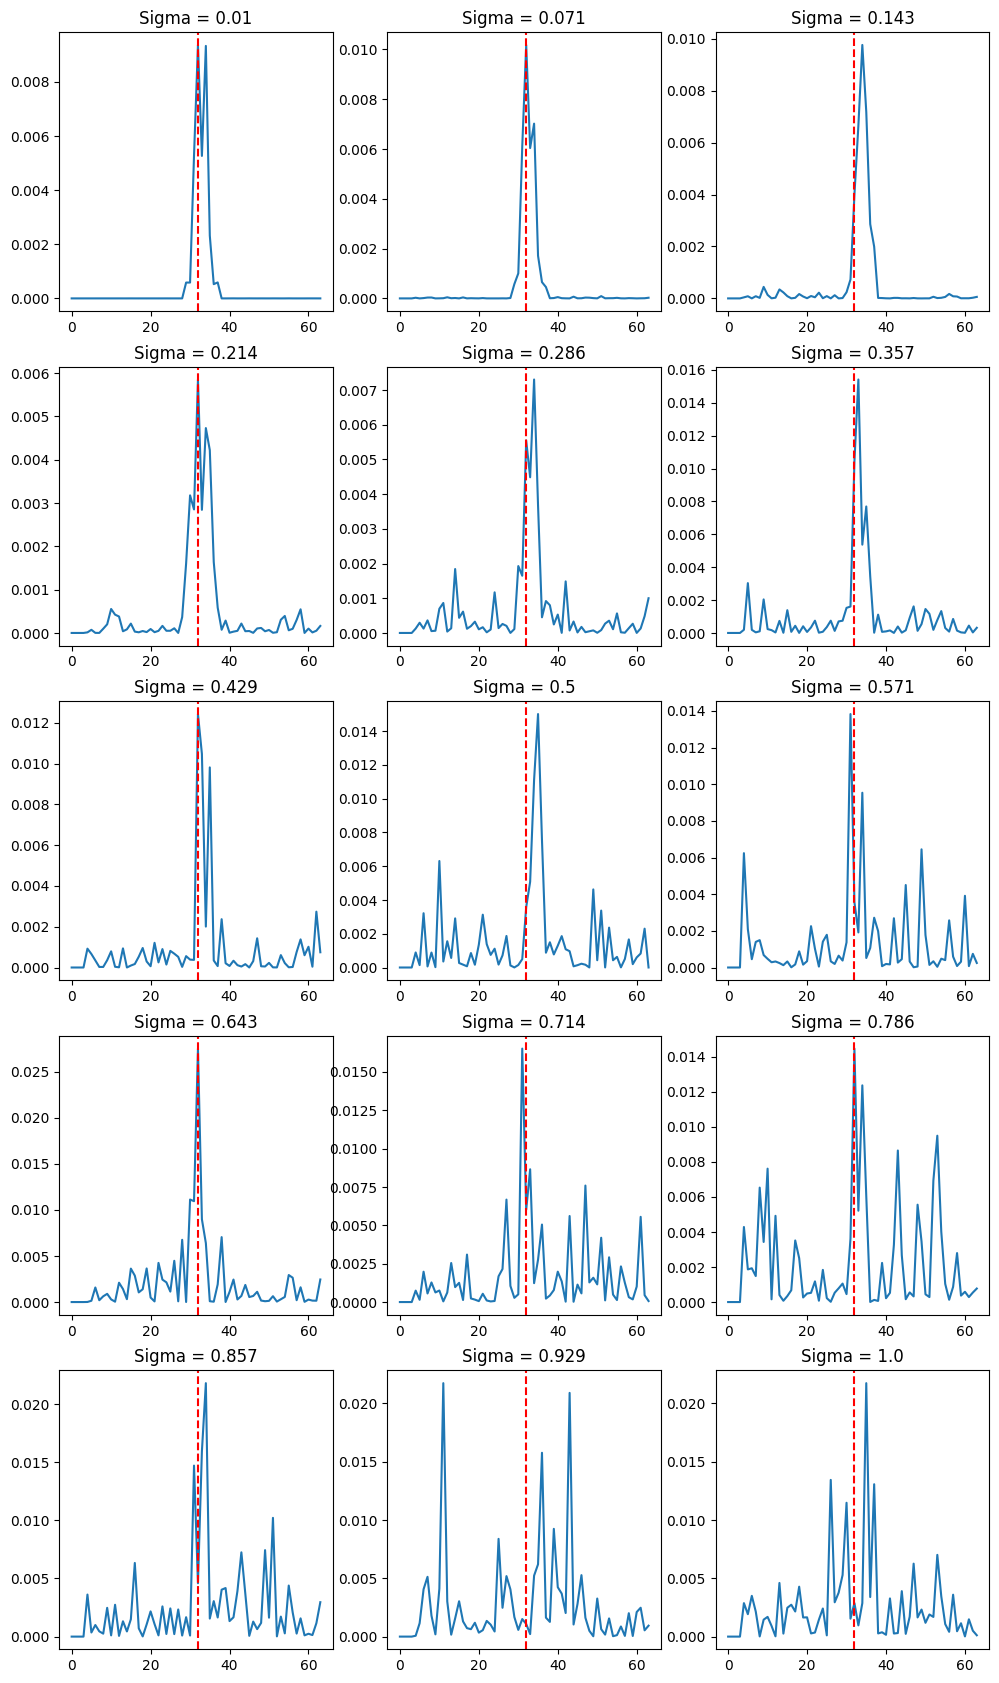

In [11]:
sigma_list = [0.01] + list(np.linspace(0, 1.0, 15))[1:]

WND_SIZE = 4

fig, axs = plt.subplots(5, 3, figsize=(12, 21)) # (n_rows, n_cols)

for i, sigma in enumerate(sigma_list):
    fake_ensemble_preds = torch.stack(
        [
            generate_synthetic_normal_cp(
                cp_loc=CP_LOC, sigma=sigma, seq_len=SEQ_LEN, cp_delta=CP_DELTA
            )[0] for _ in range(NUM_MODELS)
        ]
    )
    mmd_scores = mmd.sliding_window_mmd(fake_ensemble_preds, WND_SIZE, kernel="rbf")
    
    axs[i // 3, i % 3].plot(mmd_scores, label="Sliding window MMD scores")
    axs[i // 3, i % 3].axvline(32, linestyle="--", c="red", label="True CP loc")
    axs[i // 3, i % 3].set_title(f"Sigma = {np.round(sigma, 3)}")

# Experiments: Beta

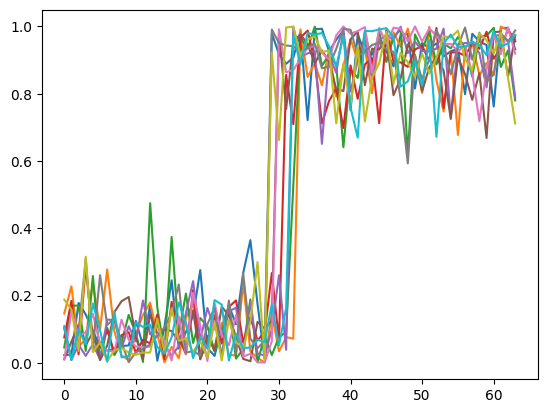

In [12]:
NUM_MODELS = 10
CP_LOC = 32
SEQ_LEN = 64
CP_DELTA = 3
CONC_NORM = (1, 10)
CONC_ABNORM = (10, 1)

beta_ensemble_preds = torch.stack(
    [
        generate_synthetic_beta_cp(
            cp_loc=CP_LOC, conc_norm=CONC_NORM, conc_abnorm=CONC_ABNORM, seq_len=SEQ_LEN, cp_delta=CP_DELTA
        )[0] for _ in range(NUM_MODELS)
    ]
)

plt.plot(beta_ensemble_preds.T);

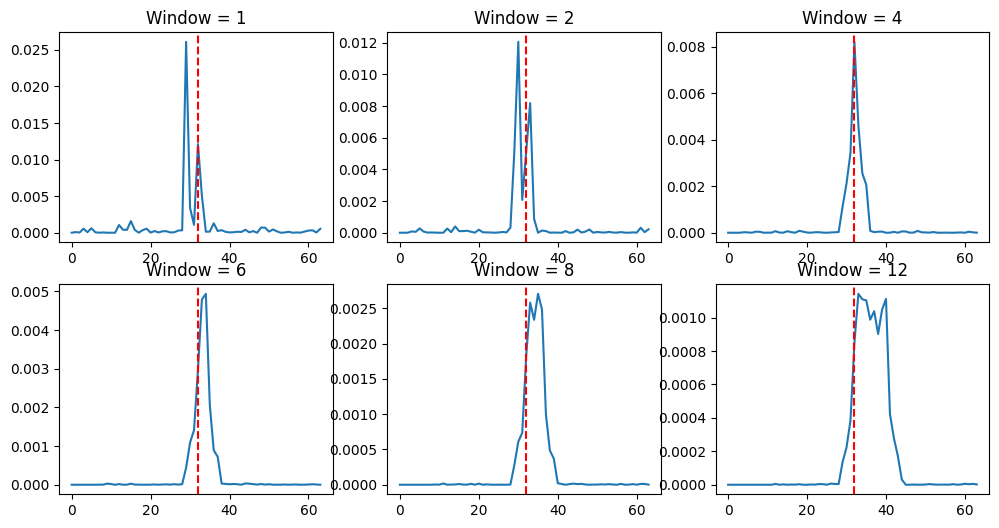

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6)) # (n_rows, n_cols)

for i, wnd_size in enumerate([1, 2, 4, 6, 8, 12]):
    mmd_scores = mmd.sliding_window_mmd(beta_ensemble_preds, wnd_size, kernel="rbf")
    axs[i // 3, i % 3].plot(mmd_scores, label="Sliding window MMD scores")
    axs[i // 3, i % 3].axvline(32, linestyle="--", c="red", label="True CP loc")
    axs[i // 3, i % 3].set_title(f"Window = {wnd_size}")

In [14]:
conc_list = [1.] + list(np.linspace(0, 40, 12))[1:]
conc_list

[1.0,
 3.6363636363636362,
 7.2727272727272725,
 10.909090909090908,
 14.545454545454545,
 18.18181818181818,
 21.818181818181817,
 25.454545454545453,
 29.09090909090909,
 32.72727272727273,
 36.36363636363636,
 40.0]

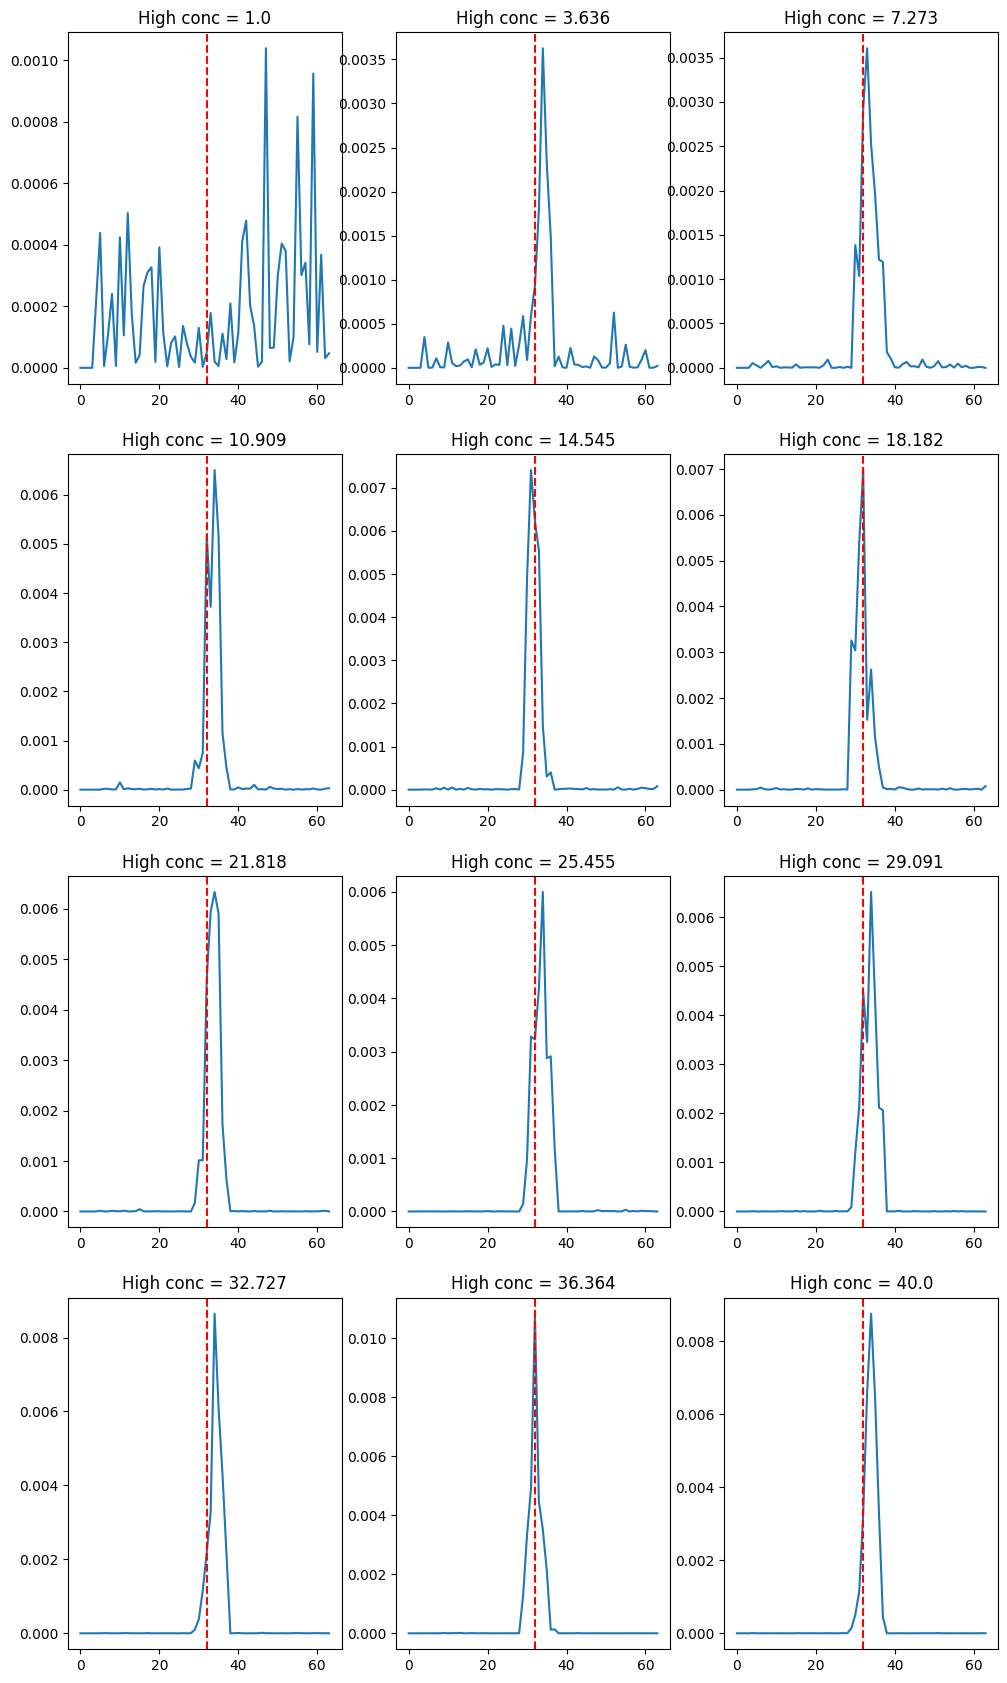

In [15]:
CP_DELTA = 3
WND_SIZE = 4

fig, axs = plt.subplots(4, 3, figsize=(12, 21)) # (n_rows, n_cols)

for i, conc in enumerate(conc_list):
    beta_ensemble_preds = torch.stack(
        [
            generate_synthetic_beta_cp(
                cp_loc=CP_LOC, conc_norm=(1, conc), conc_abnorm=(conc, 1), seq_len=SEQ_LEN, cp_delta=CP_DELTA
            )[0] for _ in range(NUM_MODELS)
        ]
    )
    mmd_scores = mmd.sliding_window_mmd(beta_ensemble_preds, WND_SIZE, kernel="rbf")
    
    axs[i // 3, i % 3].plot(mmd_scores, label="Sliding window MMD scores")
    axs[i // 3, i % 3].axvline(32, linestyle="--", c="red", label="True CP loc")
    axs[i // 3, i % 3].set_title(f"High conc = {np.round(conc, 3)}")

# Real ensembles: TSCP on YAHOO

In [17]:
model_type = "tscp"

experiments_name = "yahoo"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 4

args_config["learning"]["accelerator"] = 'cpu'
args_config["learning"]["devices"] = 1

train_dataset, test_dataset = datasets.CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False)
test_dataloader_shuffle = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=True)

In [5]:
ens_yahoo_tscp = EnsembleCPDModel(args_config, n_models=10)
ens_yahoo_tscp.load_models_list(
    f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}"
)

In [10]:
test_batch, test_labels = next(iter(test_dataloader_shuffle))

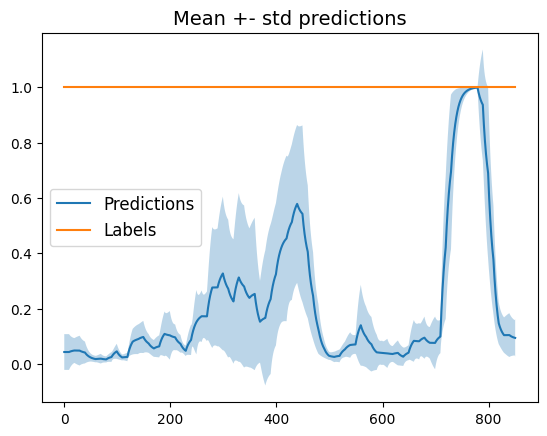

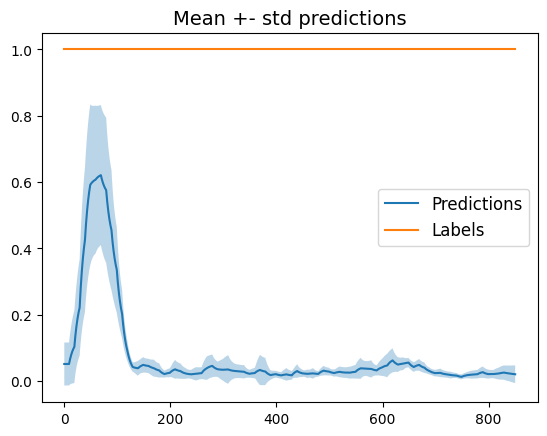

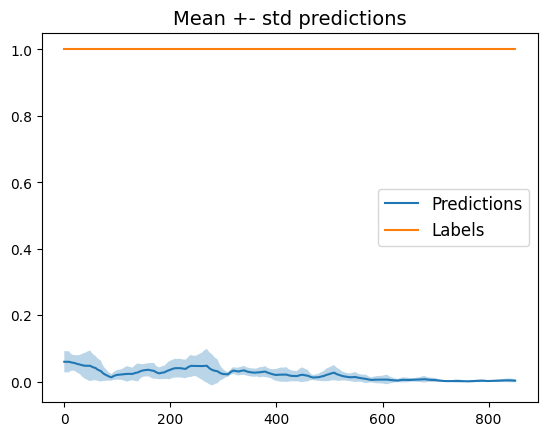

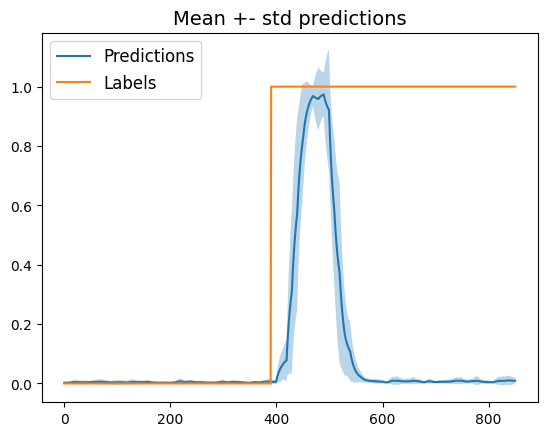

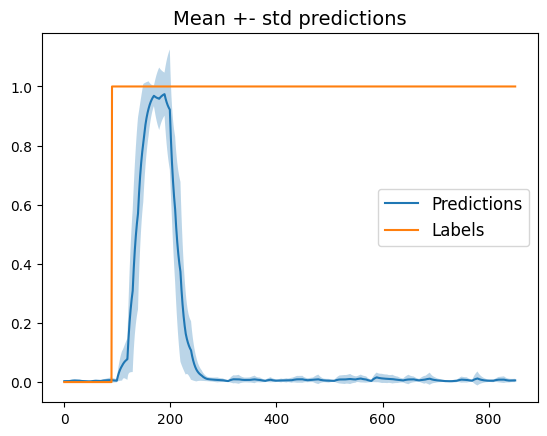

In [ ]:
visualize_predictions(
    ens_yahoo_tscp,
    model_type="ensemble",
    sequences_batch=test_batch,
    labels_batch=test_labels,
    n_pics=5,
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"],
)

In [ ]:
mmd_yahoo_tscp = MMDEnsembleCPDModel(args_config, n_models=10, window_size=50, mmd_threshold=1e-5, kernel="rbf")
mmd_yahoo_tscp.load_models_list(
    f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}"
)
mmd_yahoo_tscp.to("cuda")


In [ ]:
mmd_labels = mmd_yahoo_tscp.predict(
    test_batch,
    scale=args_config["predictions"]["scale"], 
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"]
)
mmd_labels.shape


In [11]:
_ = ens_yahoo_tscp.predict(
    test_batch,
    scale=args_config["predictions"]["scale"], 
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"]
)
ens_preds = ens_yahoo_tscp.preds
ens_preds.shape

torch.Size([10, 128, 851])

In [12]:
crop_size = test_labels.shape[-1] - ens_preds.shape[-1]
test_labels = test_labels[:, crop_size:]

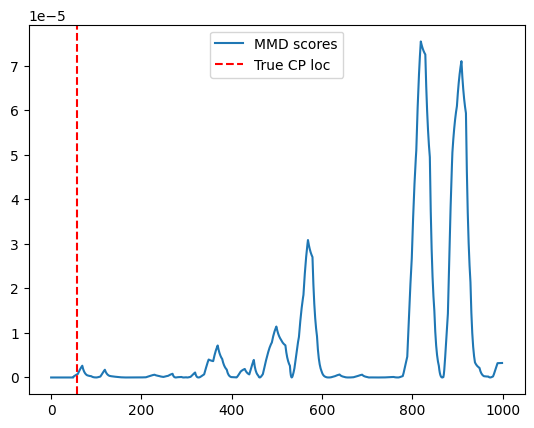

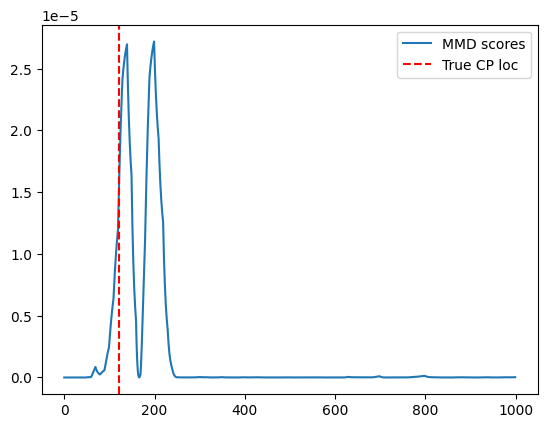

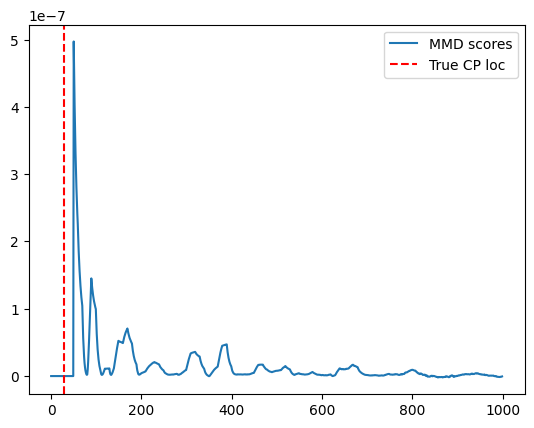

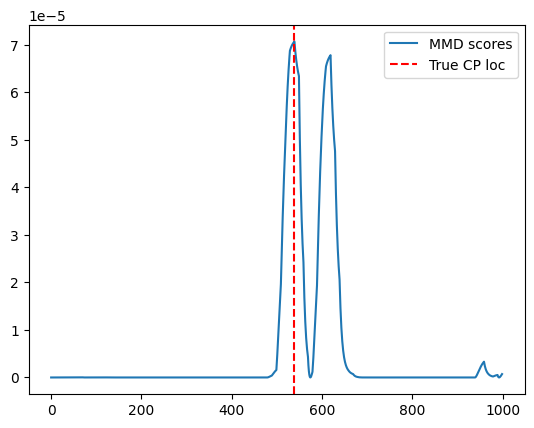

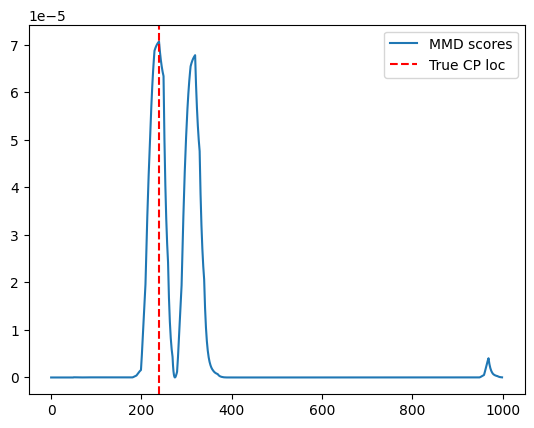

In [ ]:
for IDX in range(5):
    mmd_scores = mmd.mmd_scores_batch[IDX]
    mmd_scores_norm = (mmd_scores - mmd_scores.min()) / (mmd_scores.max() - mmd_scores.min())
    cp = test_labels[IDX].argmax().item()
    #plt.plot(mmd_scores_norm, label="Normalized MMD scores")
    plt.plot(mmd_scores, label="MMD scores")
    plt.axvline(cp, linestyle="--", c="red", label="True CP loc")
    #plt.plot(ens_preds[:, IDX, :].mean(dim=0), label="Mean ens score")
    plt.legend()
    plt.show()

# TS-CP for HAR

In [4]:
model_type = "tscp"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 4

args_config["learning"]["accelerator"] = 'cpu'
args_config["learning"]["devices"] = 1

train_dataset, test_dataset = datasets.CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False)
test_dataloader_shuffle = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=True)

In [5]:
ens_har_tscp = EnsembleCPDModel(args_config, n_models=10)
ens_har_tscp.load_models_list(
    f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}"
)

In [20]:
test_batch, test_labels = next(iter(test_dataloader_shuffle))
test_labels.shape, test_batch.shape

(torch.Size([8, 20]), torch.Size([8, 20, 28]))

In [21]:
_ = ens_har_tscp.predict(
    test_batch,
    scale=args_config["predictions"]["scale"], 
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"]
)
ens_preds = ens_har_tscp.preds
ens_preds.shape

torch.Size([10, 8, 20])

Desired number of pictures is greater than size of the batch provided.


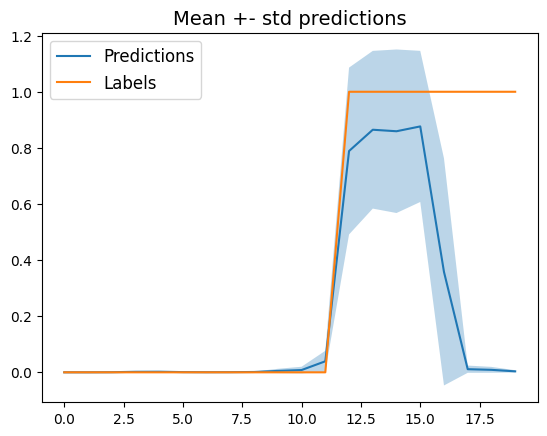

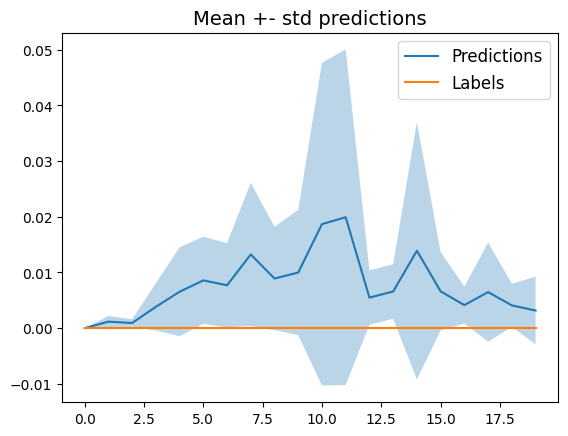

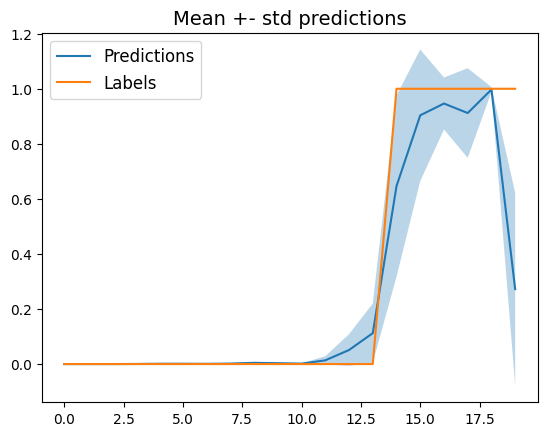

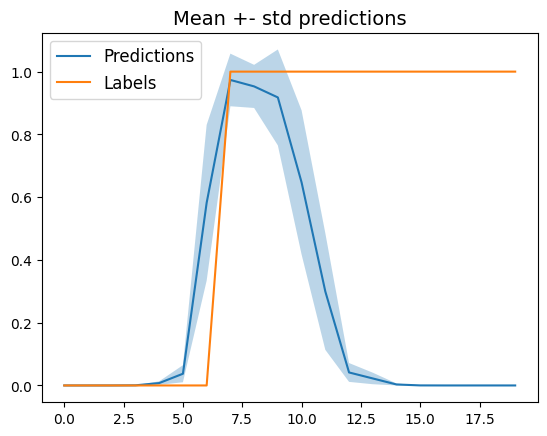

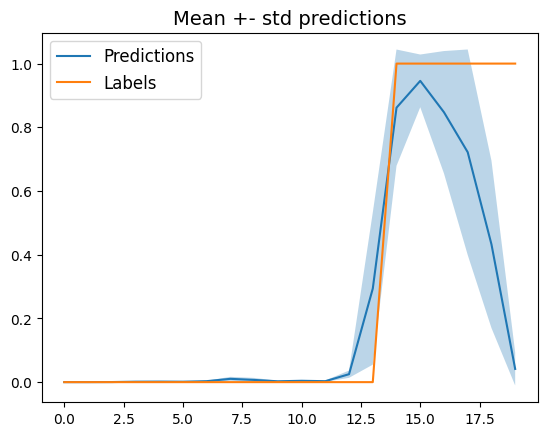

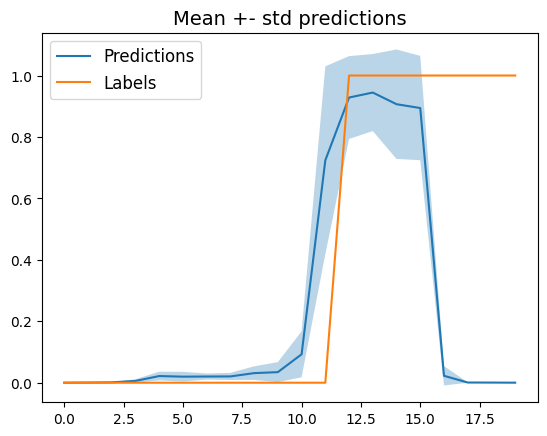

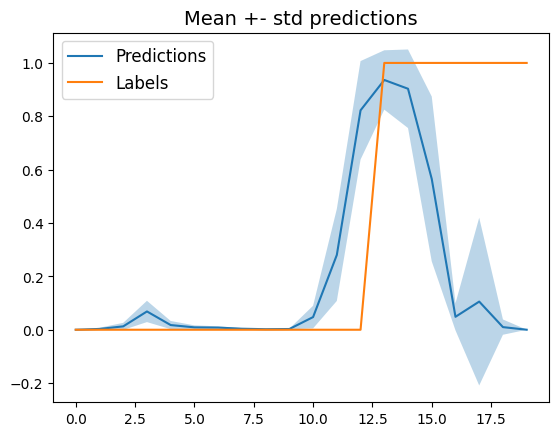

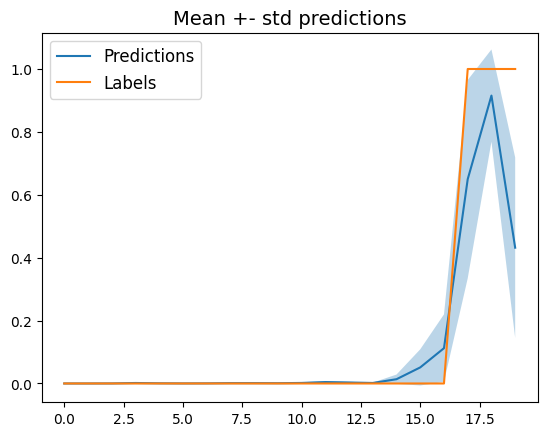

In [22]:
visualize_predictions(
    ens_har_tscp,
    model_type="ensemble",
    sequences_batch=test_batch,
    labels_batch=test_labels,
    n_pics=20,
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"],
)

In [6]:
mmd_har_tscp = MMDEnsembleCPDModel(args_config, n_models=10, window_size=2, mmd_threshold=1e-5, kernel="rbf")
mmd_har_tscp.load_models_list(
    f"saved_models/{model_type}/{experiments_name}/window_{args_config['model']['window']}"
)
mmd_har_tscp.to("cuda")


In [24]:
mmd_labels = mmd_har_tscp.predict(
    test_batch,
    scale=args_config["predictions"]["scale"], 
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"]
)
mmd_labels.shape


torch.Size([8, 20])

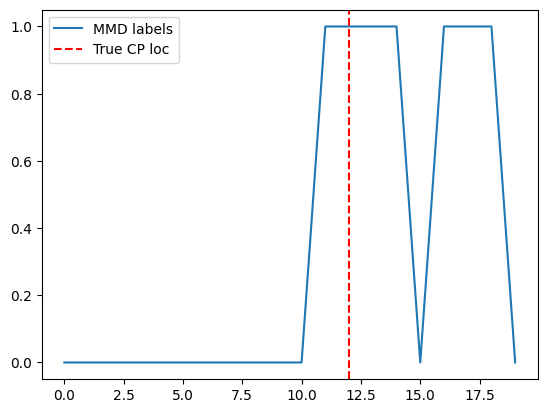

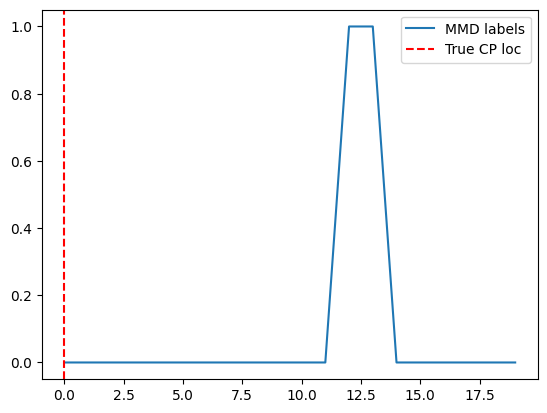

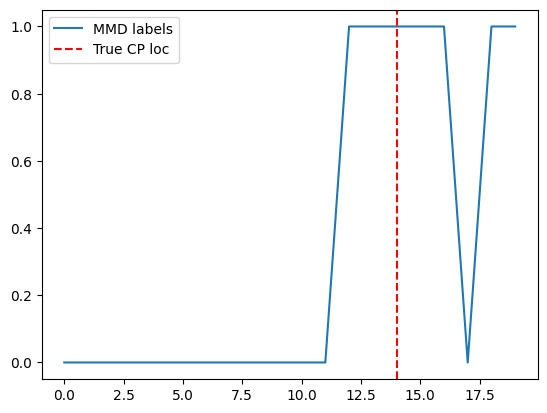

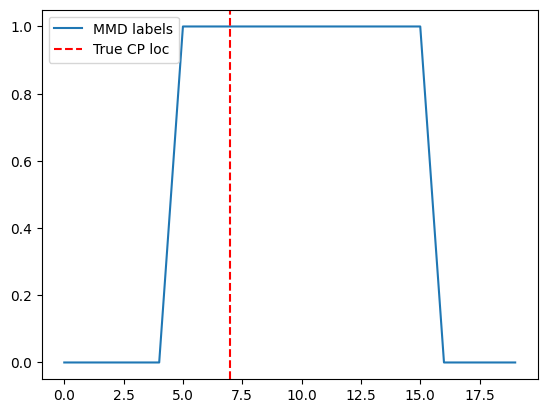

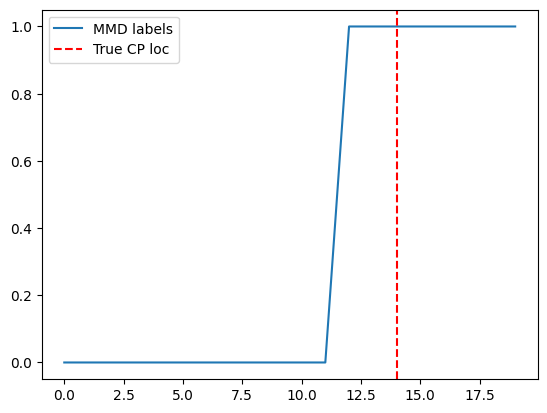

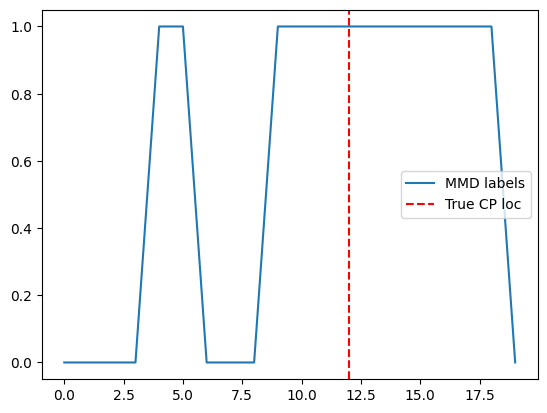

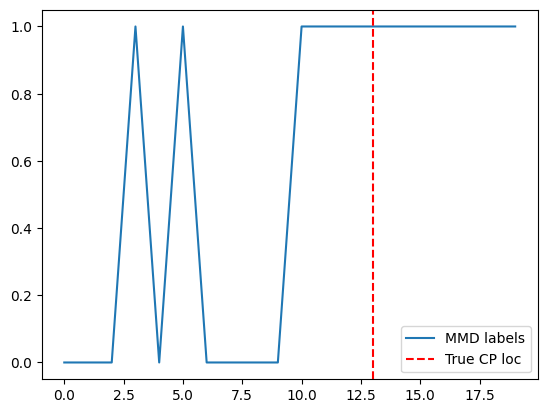

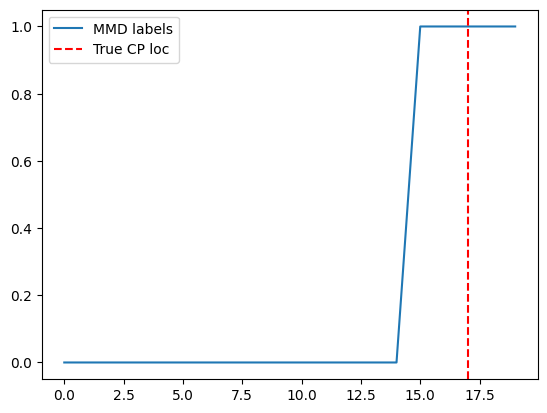

In [25]:
for IDX in range(8):
    cp = test_labels[IDX].argmax().item()
    plt.plot(mmd_labels[IDX], label="MMD labels")
    plt.axvline(cp, linestyle="--", c="red", label="True CP loc")
    #plt.plot(ens_preds[:, IDX, :].mean(dim=0), label="Mean ens score")
    plt.legend()
    plt.show()

## Metrics for MMD-based predictions

In [8]:
model_type = "seq2seq"

experiments_name = "road_accidents"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())
    
args_config['loss_type'] = "bce"

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["num_workers"] = 4

args_config["learning"]["accelerator"] = 'cuda'
args_config["learning"]["devices"] = 1

train_dataset, test_dataset = datasets.CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False)
test_dataloader_shuffle = DataLoader(test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=True)

In [10]:
ens_ra_bce = EnsembleCPDModel(args_config, n_models=10)
ens_ra_bce.load_models_list(
    f"temp_saved_models/{args_config['loss_type']}/{experiments_name}/layer_norm"
)

In [11]:
test_out = torch.load("saved_outputs/bce/road_accidents/ra_all_models_test_preds.pt")
test_labels = torch.load("saved_outputs/bce/road_accidents/ra_test_labels.pt")

test_out.shape, test_labels.shape

(torch.Size([315, 10, 16]), torch.Size([315, 16]))

In [6]:
test_out_bank, test_uncertainties_bank, test_labels_bank = metrics.collect_model_predictions_on_set(
    model=ens_har_tscp,
    test_loader=test_dataloader,
    model_type="ensemble_all_models",
    device="cpu",
    scale=args_config["predictions"]["scale"],
    step=args_config["predictions"]["step"],
    alpha=args_config["predictions"]["alpha"],
)

  0%|          | 0/168 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 168/168 [01:23<00:00,  2.02it/s]


In [17]:
from torch.utils.data import Dataset

'''
class AllModelsOutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out_bank, test_labels_bank):
        super().__init__()

        self.test_out = list(
            torch.cat(test_out_bank[:-1], dim=1).transpose(0, 1)
        )  # drop last batch
        # every prediction is (n_models, batch_size, seq_len)
        self.test_labels = list(torch.vstack(test_labels_bank[:-1]))
        #self.test_uncertainties = [None for _ in self.test_labels] 

    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return self.test_out[idx], self.test_labels[idx]
'''

class AllModelsOutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out, test_labels):
        super().__init__()

        self.test_out = test_out
        self.test_labels = test_labels

    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return self.test_out[idx], self.test_labels[idx]

In [22]:
all_preds_dataset = AllModelsOutputDataset(test_out, test_labels)
all_preds_dataloader = DataLoader(all_preds_dataset, batch_size=64)

ensemble_preds_batch, labels_batch = next(iter(all_preds_dataloader))

ensemble_preds_batch.shape, labels_batch.shape

(torch.Size([64, 10, 16]), torch.Size([64, 16]))

In [23]:
mmd_scores = mmd.sliding_window_mmd_batch(
    ensemble_preds_batch.transpose(0, 1), window_size=2, kernel="rbf"
)

mmd_scores.shape

torch.Size([64, 16])

In [35]:
mmd_scores.min(), mmd_scores.max()

(tensor(-1.6689e-08), tensor(0.0279))

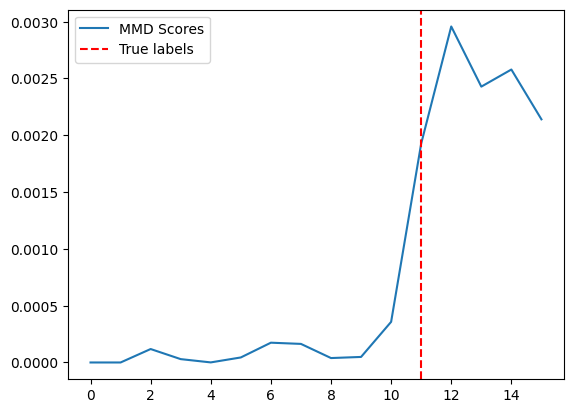

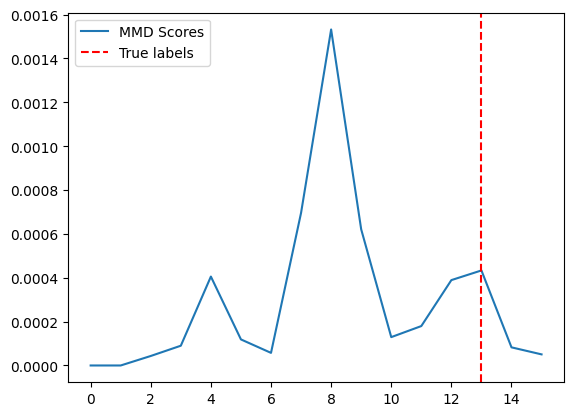

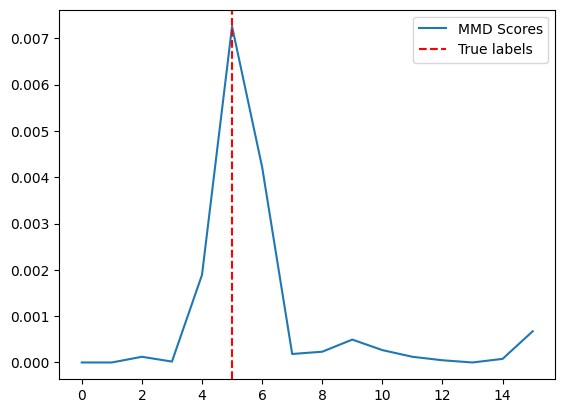

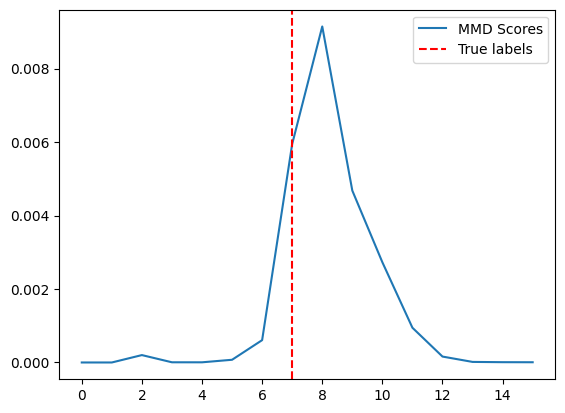

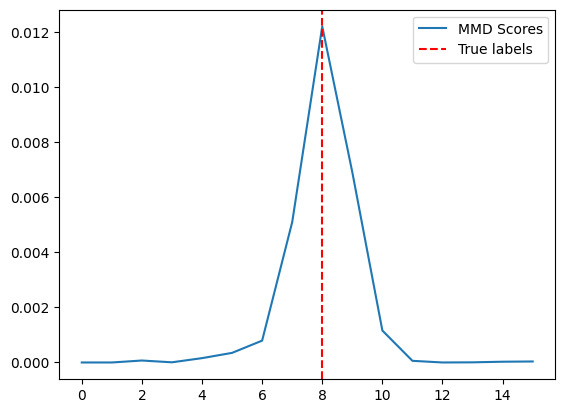

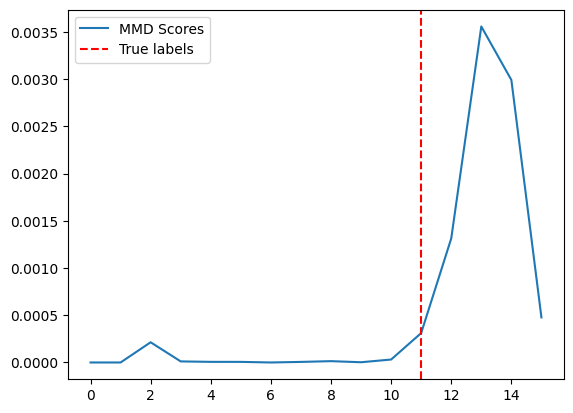

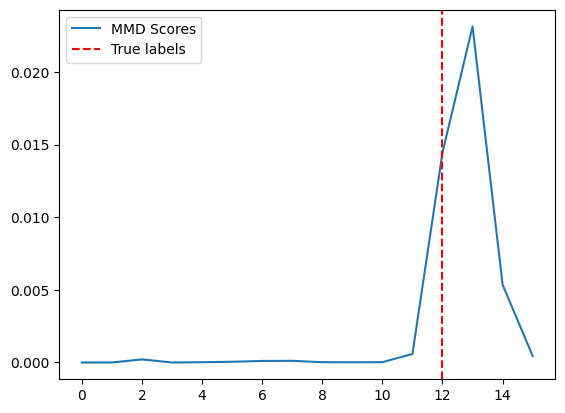

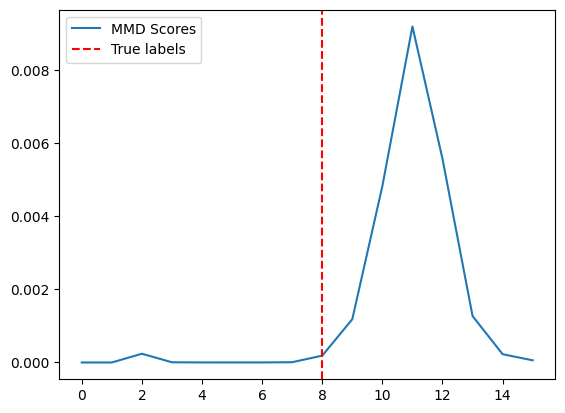

In [30]:
for IDX in range(8):
    cp = labels_batch[IDX].argmax().item()
    plt.figure()
    #plt.plot(ensemble_preds_batch[IDX].mean(dim=0), label="Mean preds")
    plt.plot(mmd_scores[IDX], label="MMD Scores")
    if cp > 0:
        plt.axvline(cp, label="True labels", c="r", linestyle="--")
    plt.legend()
    plt.show()

In [36]:
mmd_threshold_list = np.linspace(5e-6, 5e-2, 100)

for window_size in [1, 2, 3]:

res = metrics.evaluate_mmd_ensemble_model(
    mmd_threshold_list=mmd_threshold_list,
    output_dataloader=all_preds_dataloader,
    margin_list=[1, 2, 4, 8],
    args_config=args_config,
    n_models=10,
    window_size=2,
    kernel="rbf",
    save_path=f"temp_saved_models/{args_config['loss_type']}/{experiments_name}/layer_norm",
    device="cpu",
    verbose=True,
)

IndentationError: expected an indented block after 'for' statement on line 3 (4149495936.py, line 5)

In [34]:
res

{1e-05: (0.0,
  2.028571367263794,
  0.0031746032182127237,
  0.006329113924050633,
  0.8583705357142857,
  0.8583705357142857,
  {1: 0.006329113924050633,
   2: 0.006329113924050633,
   4: 0.03125,
   8: 0.05555555555555555}),
 0.005005: (0.0,
  15.574603080749512,
  0.08888889104127884,
  0.5333333333333333,
  0.986408980679814,
  0.986408980679814,
  {1: 0.5333333333333333,
   2: 0.5806451612903226,
   4: 0.625,
   8: 0.6666666666666666}),
 0.01: (0.0,
  15.831746101379395,
  0.19365079700946808,
  0.5714285714285714,
  0.9875,
  0.9875,
  {1: 0.5, 2: 0.5, 4: 0.5714285714285714, 8: 0.5714285714285714})}

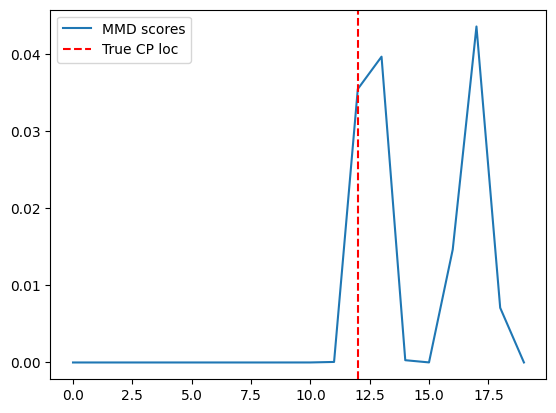

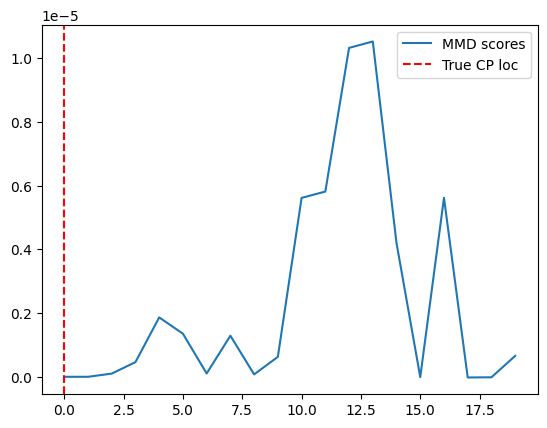

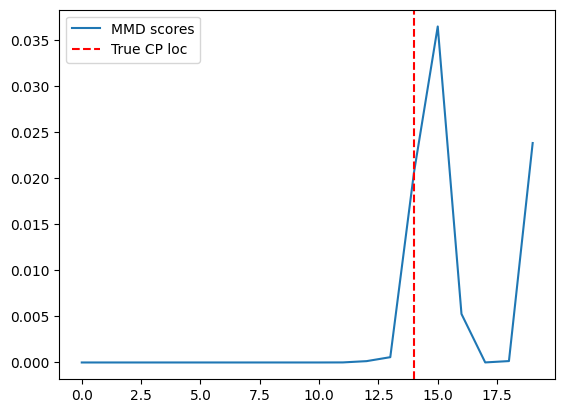

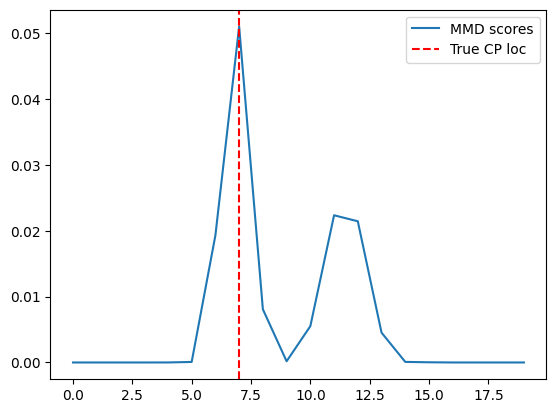

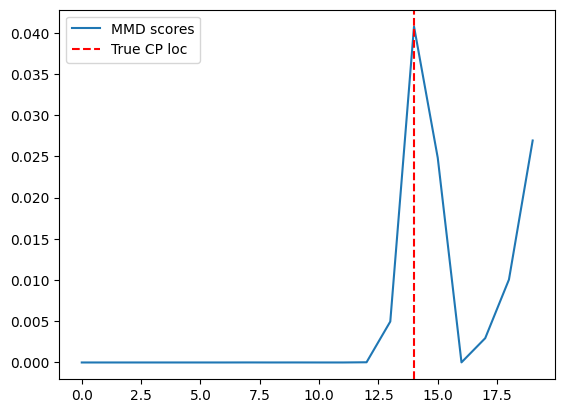

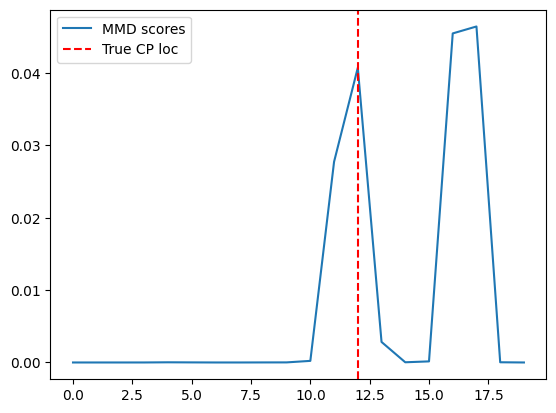

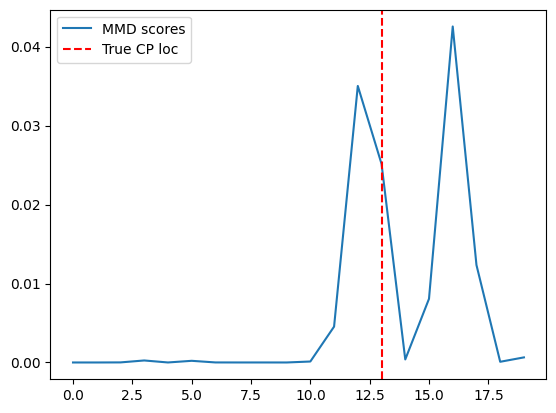

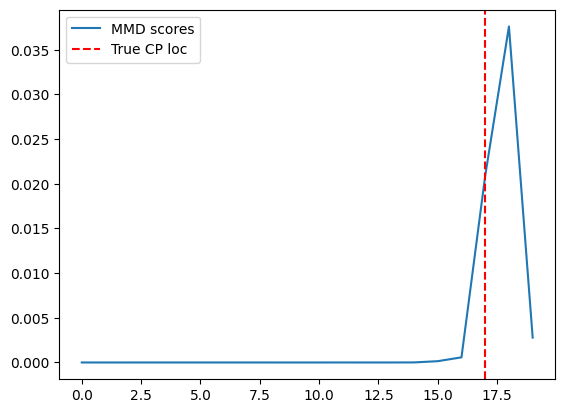

In [11]:
#SCALE = 1e5

mmd_scores_batch = mmd.sliding_window_mmd_batch(ens_preds, window_size=2, kernel="rbf")# * SCALE

for IDX in range(8): #IDX = 1

    mmd_scores = mmd_scores_batch[IDX]
    mmd_scores_norm = (mmd_scores - mmd_scores.min()) / (mmd_scores.max() - mmd_scores.min())

    cp = test_labels[IDX].argmax().item()

    #plt.plot(mmd_scores_norm, label="Normalized MMD scores")
    plt.plot(mmd_scores, label="MMD scores")
    plt.axvline(cp, linestyle="--", c="red", label="True CP loc")
    #plt.plot(ens_preds[:, IDX, :].mean(dim=0), label="Mean ens score")
    plt.legend()
    plt.show()